In [1]:
# !pip install gspread oauth2client
# !pip install matplotlib
# !pip install japanize_matplotlib

In [19]:
#PCスペック高い人のおまじない
# import os
# os.environ['NUMEXPR_MAX_THREADS'] = '16'

In [2]:
import gspread
import matplotlib.pyplot as plt
import japanize_matplotlib
import pandas as pd
import seaborn as sns
import statistics
import pickle
import numpy as np
from oauth2client.service_account import ServiceAccountCredentials
from mpl_toolkits.mplot3d import Axes3D  #3Dplot
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression

<h1>▼スプシからデータを取得するぞ</h1>

In [3]:
#そこらへんに落ちてるのでコピペでOK
def connect_gspread(jsonf,key):
    #spreadsheetsとdriveの2つのAPIを指定する
    scope = ['https://spreadsheets.google.com/feeds','https://www.googleapis.com/auth/drive']
    #認証情報を設定する
    credentials = ServiceAccountCredentials.from_json_keyfile_name(jsonf, scope)
    gc = gspread.authorize(credentials)
    #スプレッドシートキーを用いて、sheet1にアクセスする
    SPREADSHEET_KEY = key
    worksheet = gc.open_by_key(SPREADSHEET_KEY).sheet1
    return worksheet

# jsonfile名を指定
jsonf = "tech0-team-parents-round1-6d86c1cd467c.json" #これは人によるのでコピペしても動かないぞ
# 共有設定したスプレットシートキーを指定
spread_sheet_key = "1I8mHkUaAWltvzSF3MvlsShhKl9hxvZUBC57ixJUT6gg" #https://docs.google.com/spreadsheets/d/1I8mHkUaAWltvzSF3MvlsShhKl9hxvZUBC57ixJUT6gg/edit?usp=sharing

ws = connect_gspread(jsonf,spread_sheet_key)

<h1>▼スプシからデータフレーム（df）を作成し、前処理をしていく

In [4]:
#dfを作っていくぞ
df = pd.DataFrame(ws.get_all_values()[1:], columns=ws.get_all_values()[0])
#家賃と管理費を足すために桁をそろえるぞ
df['家賃']=df['家賃'].astype('float')
df['家賃'] =df['家賃']*10000
df['家賃'] =df['家賃'].astype('int')
#管理費の欠損値を0にしてint型にかえるぞ
df['管理費'] = df['管理費'].str.replace('-', '0')
df['管理費'] = df['管理費'].astype('int')
#賃料総額を作るぞ。dfはそのまま足すと勝手に横同士で足し算してくれるぞ
df["賃料総額"]=df["家賃"]+df["管理費"]

#アパートとマンションに絞るぞ
df=df.query('種別 == "マンション" or 種別 == "アパート" ') #書き方むずすぎて草。ややこしや

<h1>▼重回帰分析の準備をしていくぞ</h1>

In [21]:
#目的変数と説明変数を決めるぞ。今回はとりあえず専有面積と築年数で家賃を考えるぞ
#[[]]にしないとあとあと標準化できないよ。[]はシリーズ、[[]]はdfを示す
x = df[["専有面積", '築年数']]
x=x.astype("int") #floatのままだとエラーする
y = df[['賃料総額']]
y=y.astype("int") #floatのままだとエラーする
x1 = df[["専有面積"]]
x2 = df[['築年数']]

# print(x.shape)
# print(y.shape)
#　xに説明変数全体、x1に説明変数として専有面積、x2に説明変数として '築年数'、yに目的変数として'賃料総額'を入力
# https://qiita.com/karaage0703/items/f38d18afc1569fcc0418

C:\Users\kazum\AppData\Local\Temp\ipykernel_17100\2443346220.py:3: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax=Axes3D(fig)


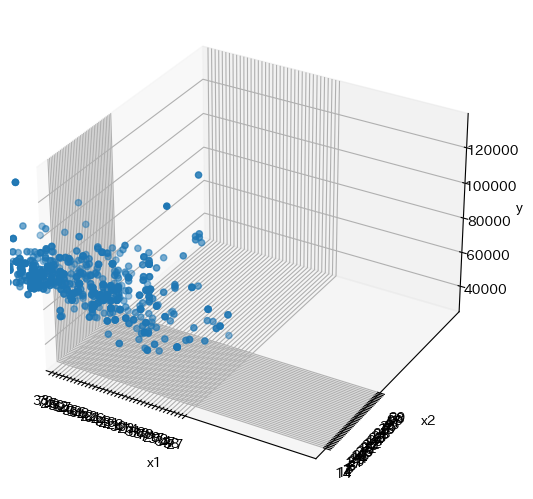

In [6]:
#おためしで現状のプロット
fig=plt.figure()
ax=Axes3D(fig)

ax.scatter3D(x1, x2, y)
ax.set_xlabel("x1")
ax.set_ylabel("x2")
ax.set_zlabel("y")

plt.show()

<h1>▼そのまま解析せずに標準化を行うぞ</h1>

In [7]:
#重回帰分析前に標準化をする
#お手軽にやるver（今回は学習に使う）
sscaler = preprocessing.StandardScaler()
sscaler.fit(x)
xss_sk = sscaler.fit_transform(x) 
sscaler.fit(y)
yss_sk = sscaler.fit_transform(y)
#アナログに計算する（他ファイルに標準化に使った標準偏差と平均渡すとき使う）

x_mean=x.mean() #df丸ごと
x_std=x.std() #df丸ごと
y_mean=y.mean()[0]
y_std=y.std()[0]
df_2=(x-x_mean)/x_std
#1個ずつ変換
y_nomalize=(y-y_mean)/y_std
x1_mean=x_mean[0]
x1_std=x_std[0]
x2_mean=x_mean[1]
x2_std=x_std[1]
Y=np.array([[y_mean,y_std]])
X=np.array([[x1_mean,x1_std],[x2_mean,x2_std]]) #説明変数ごと分ける

<h1>▼準備ができたので解析してみるぞ</h1>

In [8]:
#重回帰分析の実行
model_lr_std = LinearRegression()
analysys=model_lr_std.fit(xss_sk, yss_sk)

print("回帰係数",model_lr_std.coef_)
print("切片",model_lr_std.intercept_)
print("R",model_lr_std.score(xss_sk, yss_sk))



回帰係数 [[ 0.56576104 -0.5338962 ]]
切片 [-2.72016997e-17]
R 0.46492838919767643


<h1>▼標準化に用いた平均値と標準偏差の保存/npzファイルにして他プログラムで開けるようにするぞ</h1>

In [26]:
#標準化に用いた平均値と標準偏差の保存/npzファイルにして他プログラムで開けるようにするぞ
np.savez("statics.npz", Y=Y.astype("float32"),X=X.astype('float32'))

<h1>▼重回帰分析結果を用いて予測が成立するか試していく</h1>

In [9]:
#試しに作成した標準化モデルを再度呼び出すぞ
statics_data = np.load("statics.npz")["X"]
x1_statics=statics_data[0] #[48.101753 10.071228] 平均、標準偏差
x2_statics=statics_data[1] # [17.20103  9.054  ] 平均、標準偏差
y_statics=np.load("statics.npz")["Y"][0]


In [10]:
#お試し予測
z=[[45.39,13]] #説明変数z=[[専有面積,築年数]]
#標準化（学習モデルの標準化を利用）
z_nomalize=[[(z[0][0]-x1_statics[0])/x1_statics[1],(z[0][1]-x2_statics[0])/x2_statics[1]]]#それぞれ掛け算される
z_nomalize[0]

[-0.5533640108620965, -0.6172189123478405]

In [11]:
#標準化した説明変数で予測
predict_nomalize=model_lr_std.predict(z_nomalize)
print("予測値（標準化）",predict_nomalize)

予測値（標準化） [[0.01645904]]


In [12]:
#予測値も標準化されたままなので標準化をさらに戻す
predict=round(predict_nomalize[0][0]*y_statics[1]+y_statics[0])
print("予測値",predict,"円")

予測値 60634 円


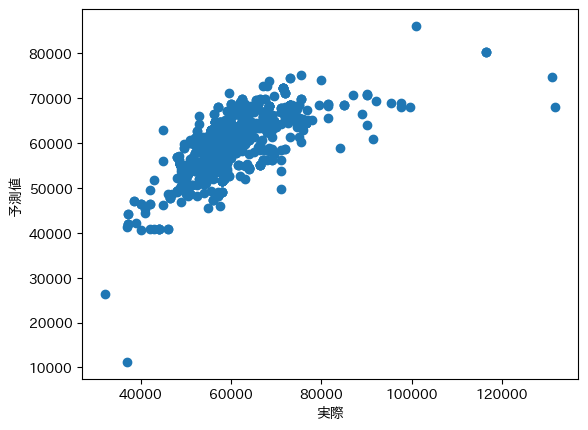

In [13]:
#実値と予測値の比較
predict_y=sscaler.inverse_transform(model_lr_std.predict(xss_sk))
plt.scatter(y,predict_y)
plt.xlabel("実際")
plt.ylabel("予測値")
plt.show()

▼4万円以下かつ10万円以上の値で精度が落ちていそう。
今回はこれらを除外して精度を上げる

<h1>▼範囲を再設定して再トライ</h1>

In [14]:
#範囲を決めて再度重回帰(重回帰の前処理～を関数にしても良いがどうせこの一回なのでそのまま書き換え)
df2=df.query('40000 <= 賃料総額 < 100000')
x = df2[["専有面積", '築年数']]
x=x.astype("int") #floatのままだとエラーする
y = df2[['賃料総額']]
y=y.astype("int") #floatのままだとエラーする
x1 = df2[["専有面積"]]
x2 = df2[['築年数']]

回帰係数 [[ 0.55291491 -0.57490662]]
切片 [-1.08645415e-16]
R 0.4400102604365079
予想結果 60734 円


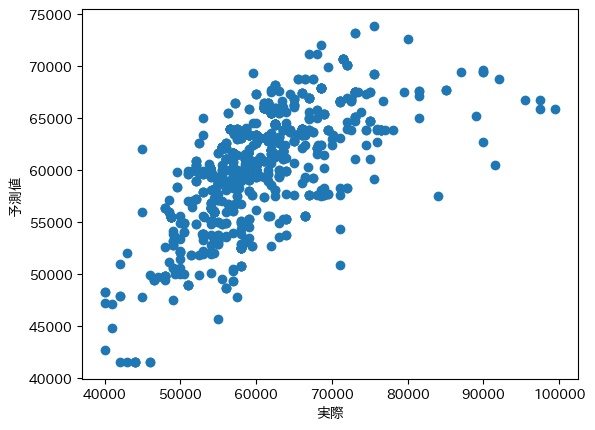

In [16]:
#重回帰分析前に標準化をする
#お手軽にやるver（今回は学習に使う）
sscaler = preprocessing.StandardScaler()
sscaler.fit(x)
xss_sk = sscaler.fit_transform(x) 
sscaler.fit(y)
yss_sk = sscaler.fit_transform(y)
#アナログに計算する（他ファイルに標準化に使った標準偏差と平均渡すとき使う）

x_mean=x.mean() #df丸ごと
x_std=x.std() #df丸ごと
y_mean=y.mean()[0]
y_std=y.std()[0]
df_2=(x-x_mean)/x_std
#1個ずつ変換
y_nomalize=(y-y_mean)/y_std
x1_mean=x_mean[0]
x1_std=x_std[0]
x2_mean=x_mean[1]
x2_std=x_std[1]
Y=np.array([[y_mean,y_std]])
X=np.array([[x1_mean,x1_std],[x2_mean,x2_std]]) #説明変数ごと分ける
#重回帰分析の実行
model_lr_std = LinearRegression()
analysys=model_lr_std.fit(xss_sk, yss_sk)

print("回帰係数",model_lr_std.coef_)
print("切片",model_lr_std.intercept_)
print("R",model_lr_std.score(xss_sk, yss_sk))

#重回帰分析結果の保存/npzファイルにして他プログラムで開けるようにするぞ
np.savez("statics.npz", Y=Y.astype("float32"),X=X.astype('float32'))
statics_data = np.load("statics.npz")["X"]
x1_statics=statics_data[0] #[48.101753 10.071228] 平均、標準偏差
x2_statics=statics_data[1] # [17.20103  9.054  ] 平均、標準偏差
y_statics=np.load("statics.npz")["Y"][0]
#お試し予測
z=[[45.39,13]] #標準化後の数字を入れないといけないのでだるい
#標準化（学習モデルの標準化を利用）
z_nomalize=[[(z[0][0]-x1_statics[0])/x1_statics[1],(z[0][1]-x2_statics[0])/x2_statics[1]]]#それぞれ掛け算される
predict_nomalize=model_lr_std.predict(z_nomalize)
#標準化をさらに戻す
print("予想結果",round(predict_nomalize[0][0]*y_statics[1]+y_statics[0]),"円")
#実値と予測値の比較
predict_y=sscaler.inverse_transform(model_lr_std.predict(xss_sk))
plt.scatter(y,predict_y)
plt.xlabel("実際")
plt.ylabel("予測値")
plt.show()

結果としては範囲を狭めても精度は向上せず、築年数と専有面積だけでは説明がついていない、ということがよくわかった。

<h1>▼Streamlitで回帰モデルを流用するためにPickleで保存するぞ</h1>

In [17]:
#学習モデルの保存
with open('model.pickle', mode='wb') as f:
    pickle.dump(model_lr_std,f,protocol=2)